In [3]:
import gurobipy as gb
import networkx as nx

#import pygraphviz as pygv


import os
from IPython.display import SVG, display

In [ ]:
#
# Drawing 
# functions
#

#
# Drawing 
# functions
#

def DrawInitialGraph():
    global DrawG
    DrawG = pygv.AGraph(directed='true',strict='true', splines='true')


    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i == root:
            DrawG.add_node (i, shape='circle', pos=pos, color="red", fontsize='8', width='0.3', fixedsize='true')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, color="black", fontsize='8', width='0.3', fixedsize='true')   	

    DrawG.layout(prog='neato', args='-n')
    DrawG.draw (path=str(basename) + '.svg', format='svg')
    DrawG.clear()


def DrawSol (x):

    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        DrawG.add_node (i, shape='circle', pos=pos,fontsize='8', width='0.3', fixedsize='true')

    DrawG.layout(prog='neato', args='-n')
    filepath=str(basename) + '_sol.svg'

    for i in G.edges():
        h = i[0]
        k = i[1]
        if x[i].x > 0.00001:
            lab = round(x[i].x,4)	
            if x[i].x > 0.999999:
                DrawG.add_edge(h, k, color='black', label=lab, fontsize='8')
            else:
                DrawG.add_edge(h, k, color='red', label=lab, fontsize='8')

    DrawG.draw (path=filepath, format='svg')
    DrawG.clear()

def DrawSubtour (x, subtour):
    for i in G.nodes():
        pos = str(G.node[i]['x'] * args.scale) + ',' + str((G.node[i]['y'])* args.scale)
        if i in subtour:
            DrawG.add_node (i, shape='circle', pos=pos, fontsize='8', width='0.3', fixedsize='true', style='filled')
        else:
            DrawG.add_node (i, shape='circle', pos=pos, fontsize='8', width='0.3', fixedsize='true')

    DrawG.layout(prog='neato', args='-n')
    filepath=str(basename) + '_sub.svg'

    for i in G.edges():
        h = i[0]
        k = i[1]
        if x[i].x > 0.00001:
            lab = round(x[i].x,4)	
            if x[i].x > 0.999999:
                DrawG.add_edge(h, k, color='black', label=lab, fontsize='8')
            else:
                DrawG.add_edge(h, k, color='red', label=lab, fontsize='8')

    DrawG.draw (path=filepath, format='svg')
    DrawG.clear()

    

In [5]:
class args:
    filename = None
    scale = 20

## ATSP

>**Given**
>A directed graph $G=(N,A)\;$ and a cost $c_{ij} > 0$ for each arc in $A$
>
>**Find**
> The tour (a directed cycle that contains all $n$ nodes) of minimal length  


### Formulation

Decision variables:
$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is in the tour} \\
0 \text{ otherwise}
\end{cases}
$$

Formulation:
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N \;\; \text{(RS)}\\
\sum_{(i,j) \in A(S)} x_{ij} &\le |S| - 1 \;\; \forall S \subset N, |S| \ge 2 \;\; \text{(SEC)}\\
x & \in \{0,1\}^{|A|}
\end{alignat}
$$

In [6]:
# 
# Read the graph in the graphML format
#


args.filename = 'atsp18072017.gml'

basename = os.path.splitext(args.filename)[0]

G = nx.read_graphml (args.filename, node_type=int)

print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

print(G.is_directed())

#print(G.edges(data=True))

G has 30 nodes and 870 edges
True


In [7]:
root = 1

#DrawInitialGraph()

#display(SVG(filename=basename+'.svg'))

In [8]:
atsp = gb.Model()

x = atsp.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.CONTINUOUS, name='x')

atsp.write('atsp.lp')

## FS constraints

In [9]:
atsp.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes()), name='FS')

atsp.update()
atsp.write('atsp.lp')

## RS constraints

In [10]:
atsp.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes()), name='RS')

atsp.update()
atsp.write('atsp.lp')

In [12]:
atsp.optimize()

#DrawSol(x)

#display(SVG(filename=basename+'_sol.svg'))

Optimize a model with 60 rows, 870 columns and 1740 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Solved in 14 iterations and 0.01 seconds
Optimal objective  2.541300000e+04


### SEC with |S|=2

In [13]:
atsp.addConstrs((x[i,j] + x[j,i] <= 1 \
                 for i,j in G.edges() if j > i), name='SEC2')

atsp.update()
atsp.write('atsp.lp')

In [15]:
atsp.optimize()

#DrawSol(x)

#display(SVG(filename=basename+'_sol.svg'))

Optimize a model with 495 rows, 870 columns and 2610 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Solved in 28 iterations and 0.02 seconds
Optimal objective  2.883300000e+04


In [17]:
atsp.objVal

28833.0

In [46]:
## Subtour Elimination Constraints: separation

In [26]:
def subtourseparation (G,x):
    for i,j in G.edges():
        G[i][j]['capacity'] = x[i,j].x
        
    for i in list(G.nodes())[1:]:
        cut_val, cut = nx.minimum_cut(G,1,i)
        if cut_val < 0.99999:
            print ('Found violated subtour inequality')
            subtour = (list(cut[0]))
            print (subtour)
            return subtour
    return None

## A basic cutting plane algorithm

Found violated subtour inequality
[1, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 28, 29, 30]


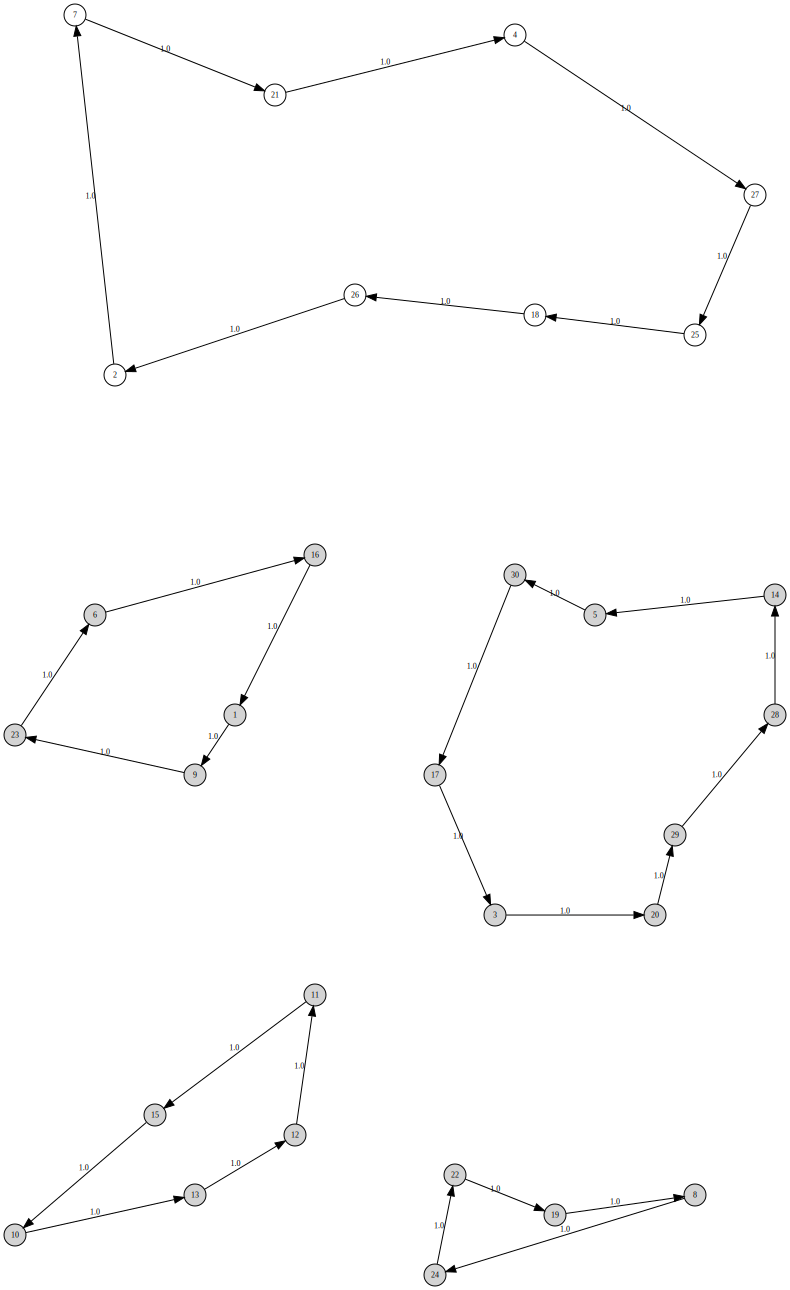

Optimize a model with 496 rows, 870 columns and 3072 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8833000e+04   1.000000e+00   0.000000e+00      0s
       1    2.8873000e+04   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds
Optimal objective  2.887300000e+04


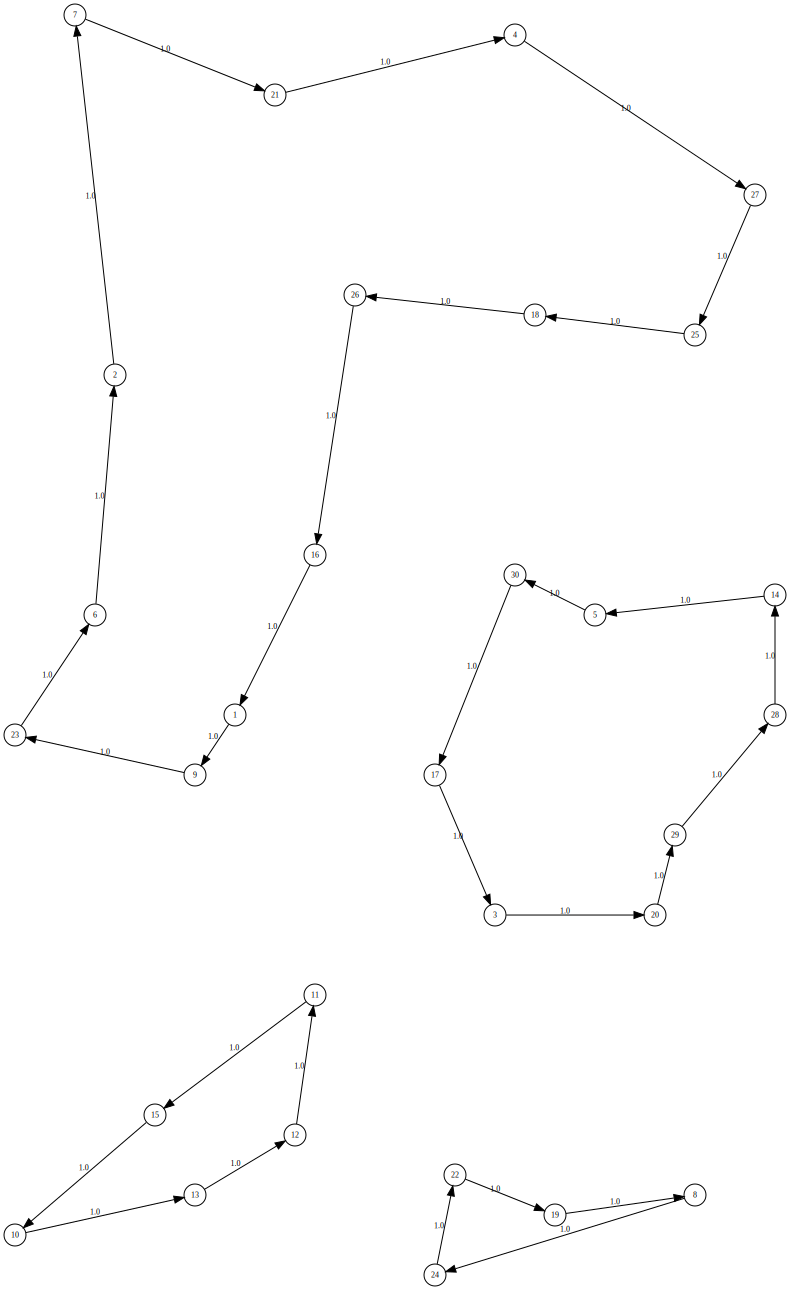

Found violated subtour inequality
[1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27]


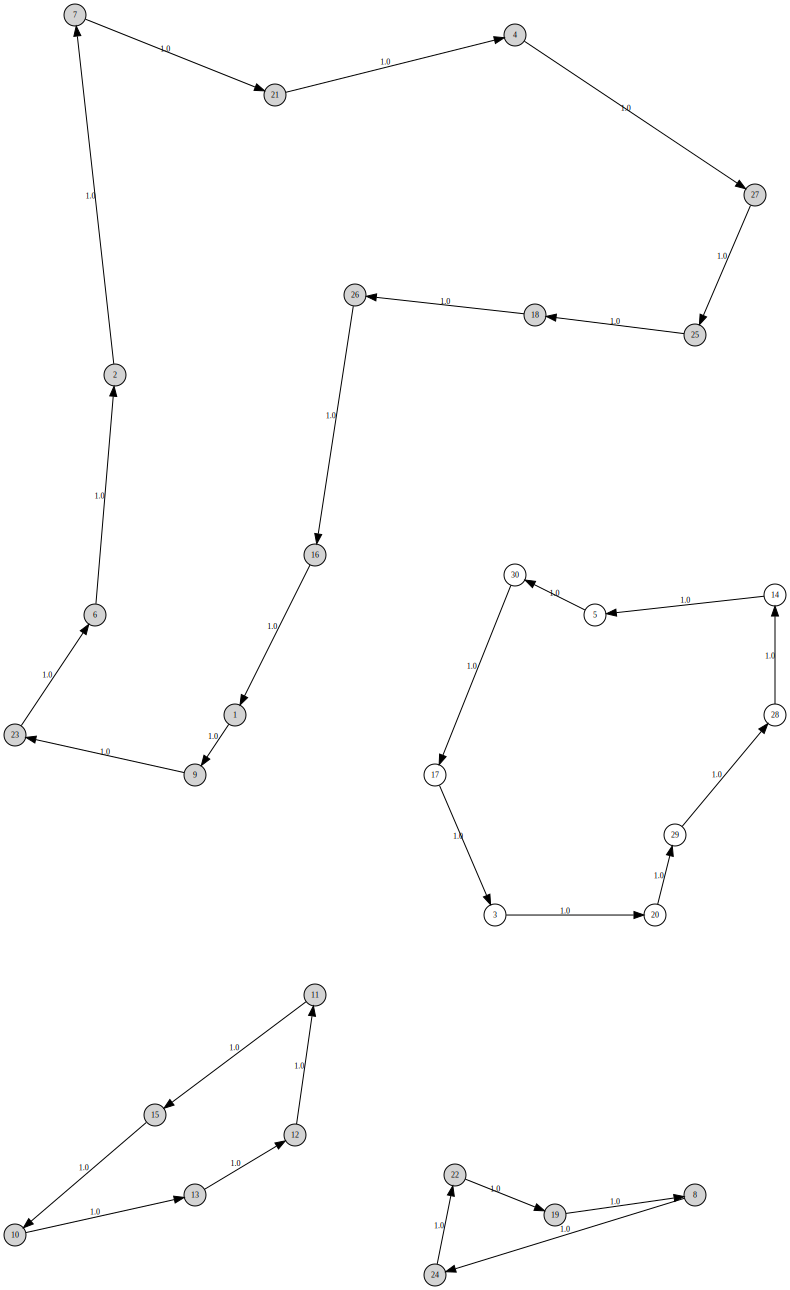

Optimize a model with 497 rows, 870 columns and 3534 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8873000e+04   1.000000e+00   0.000000e+00      0s
       1    2.8897000e+04   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.889700000e+04


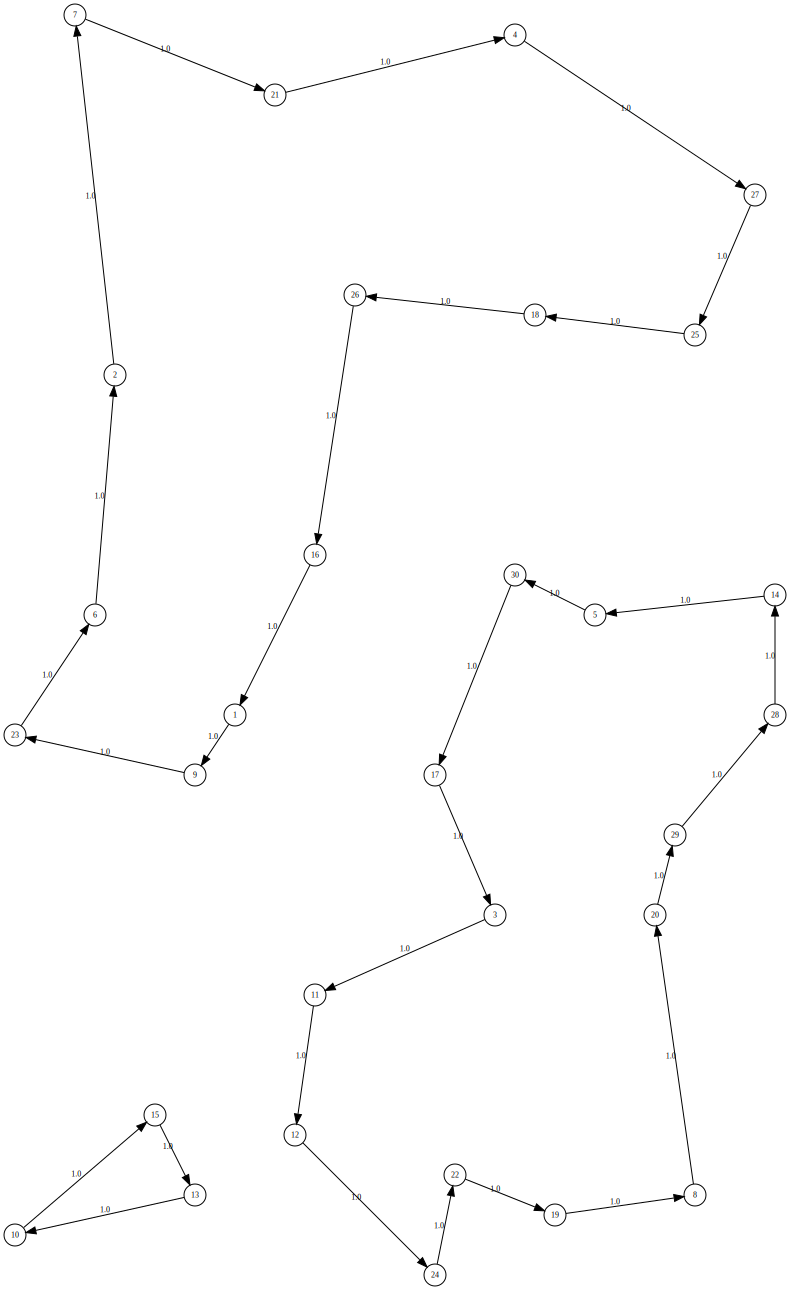

Found violated subtour inequality
[1, 2, 4, 6, 7, 9, 10, 13, 15, 16, 18, 21, 23, 25, 26, 27]


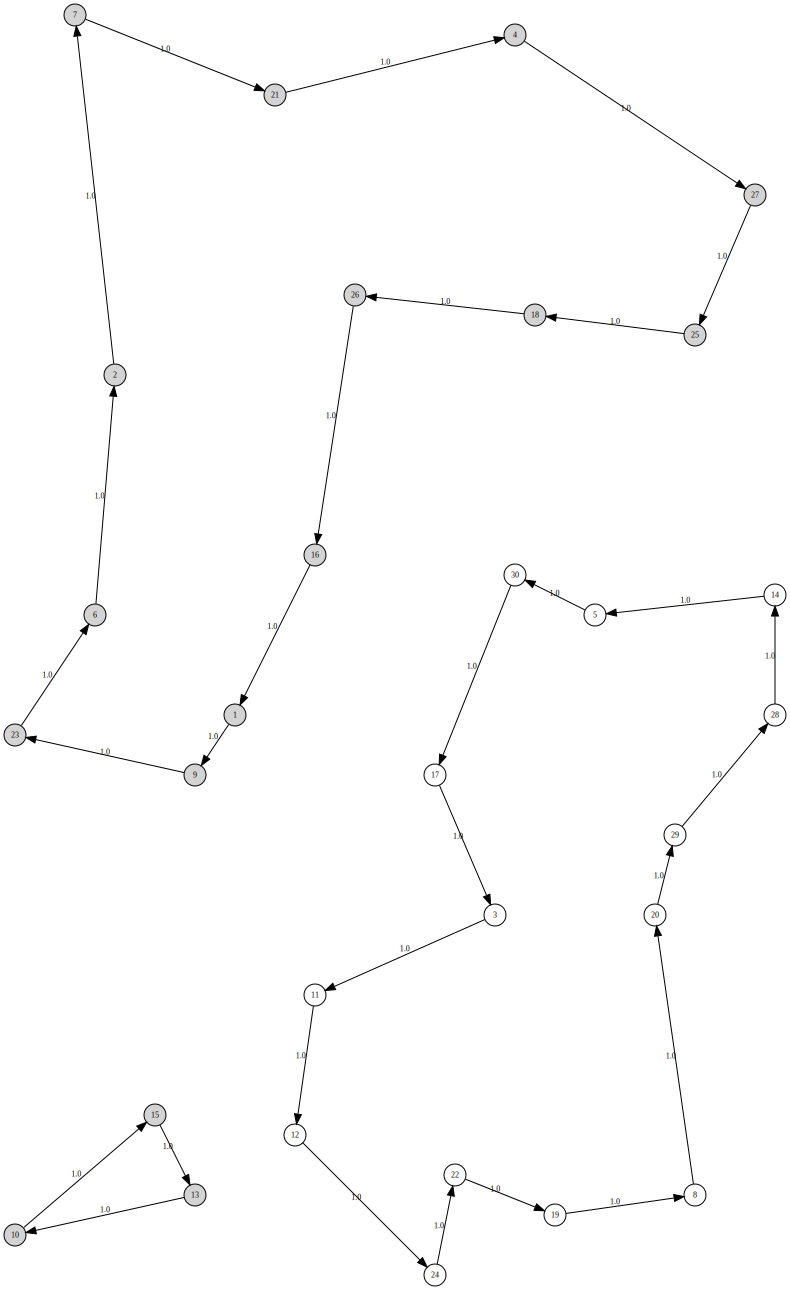

Optimize a model with 498 rows, 870 columns and 3774 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8897000e+04   1.000000e+00   0.000000e+00      0s
       6    2.8990000e+04   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.02 seconds
Optimal objective  2.899000000e+04


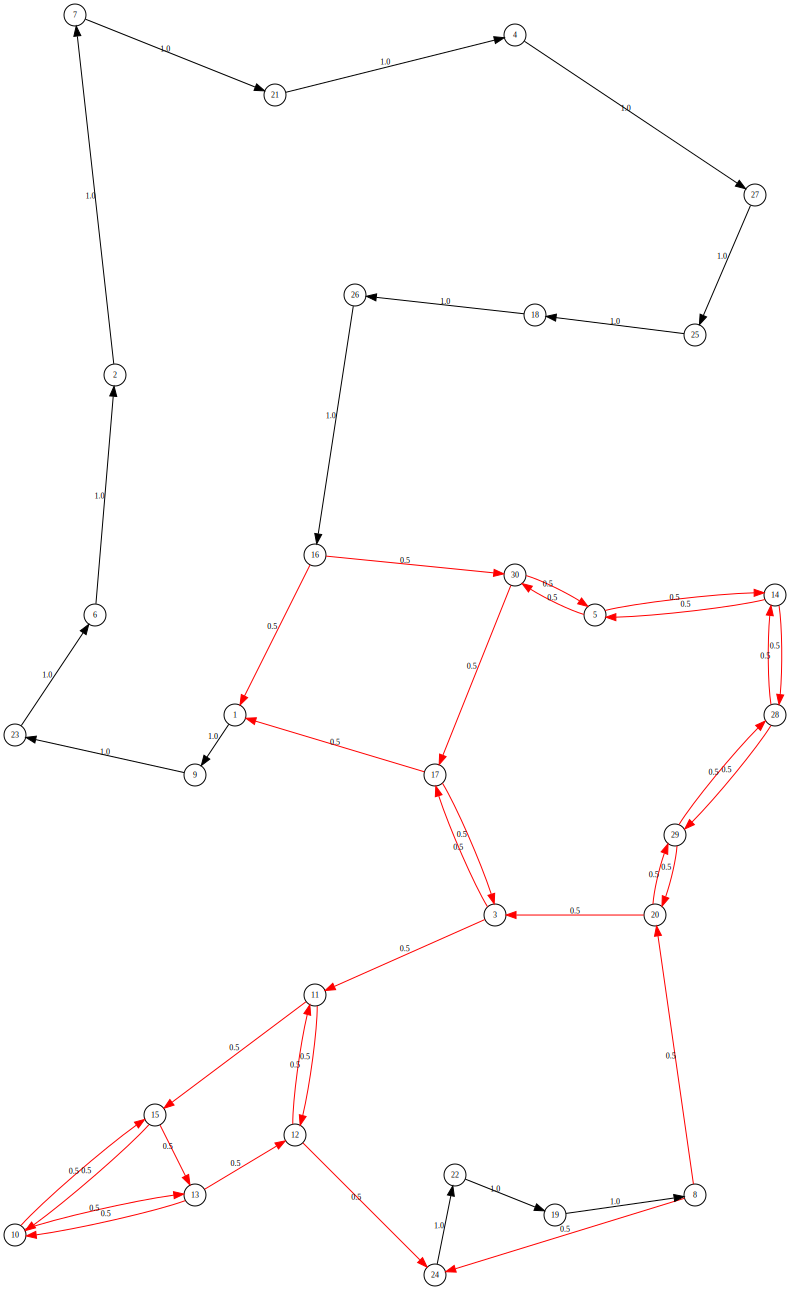

Found violated subtour inequality
[1, 2, 4, 6, 7, 9, 16, 18, 21, 23, 25, 26, 27]


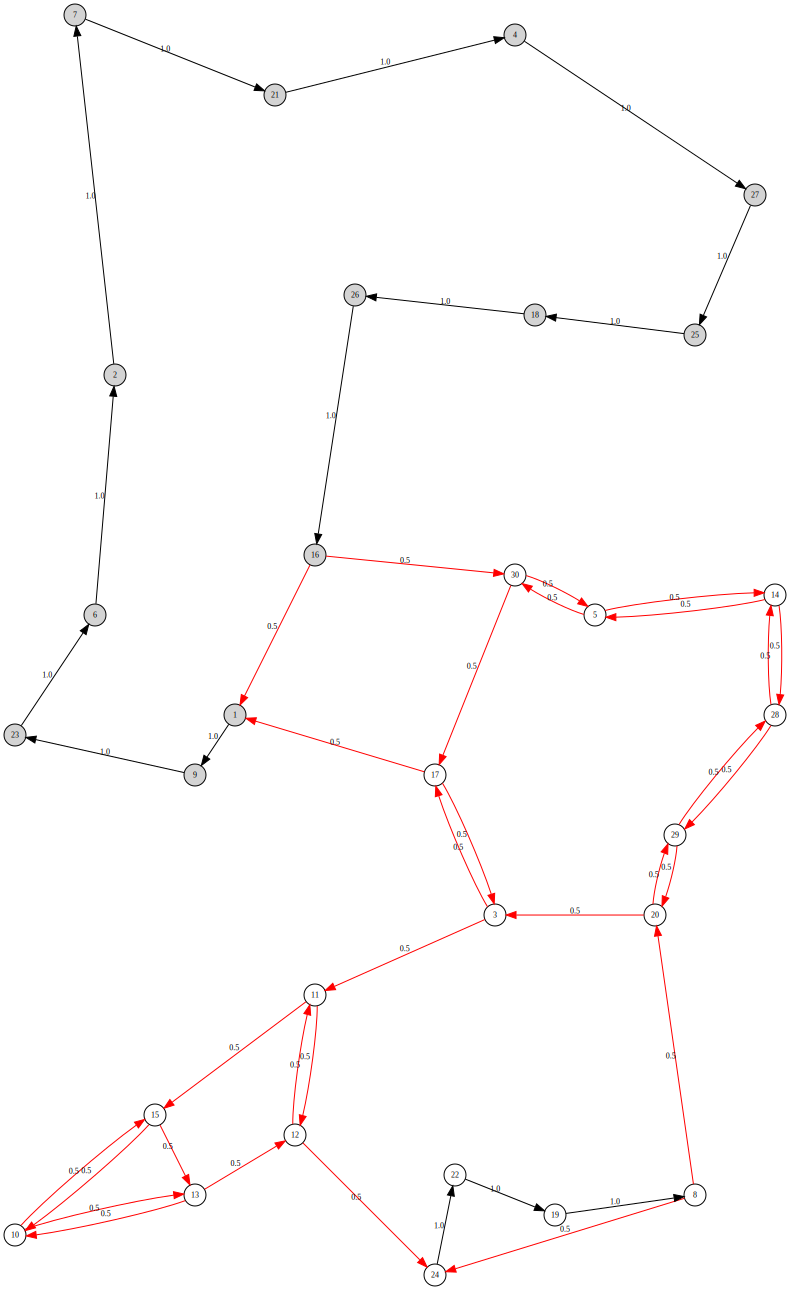

Optimize a model with 499 rows, 870 columns and 3930 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8990000e+04   5.000000e-01   0.000000e+00      0s
       1    2.9083000e+04   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  2.908300000e+04


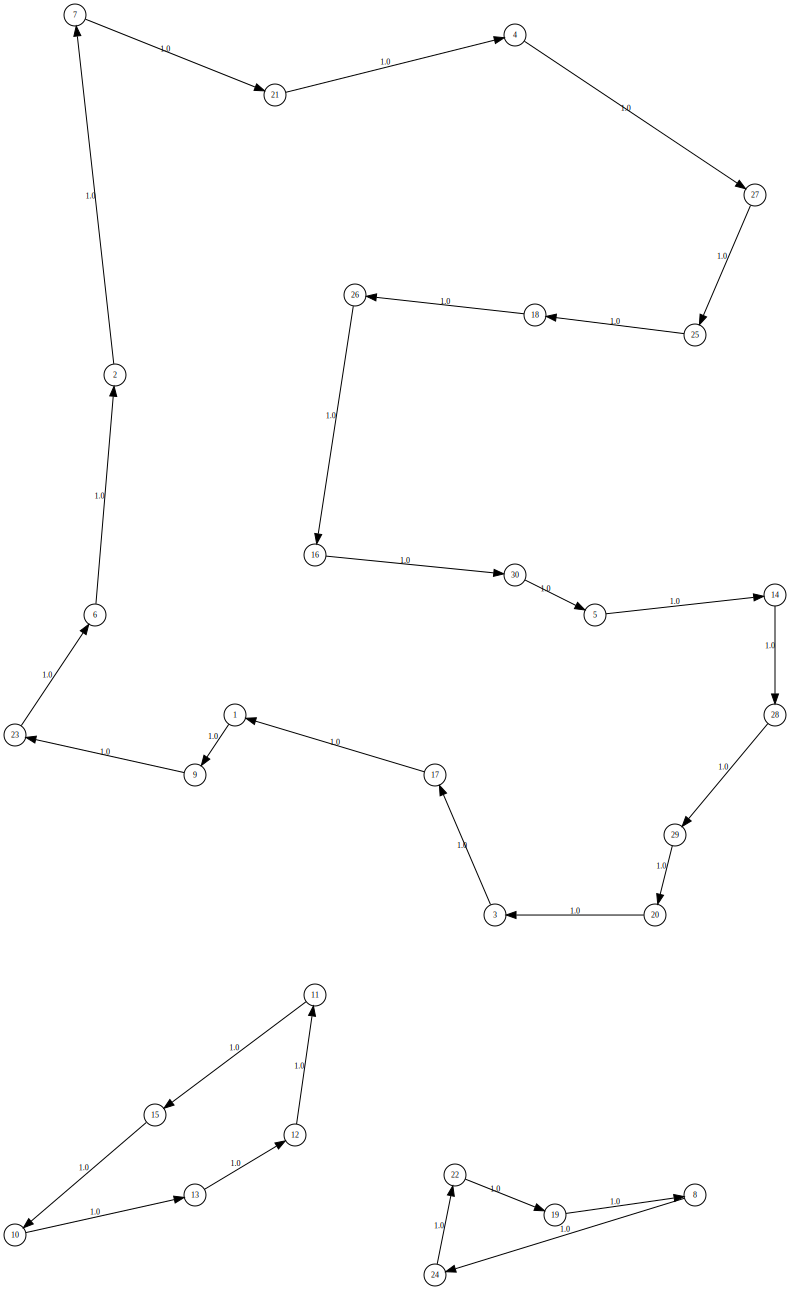

Found violated subtour inequality
[1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 23, 25, 26, 27, 28, 29, 30]


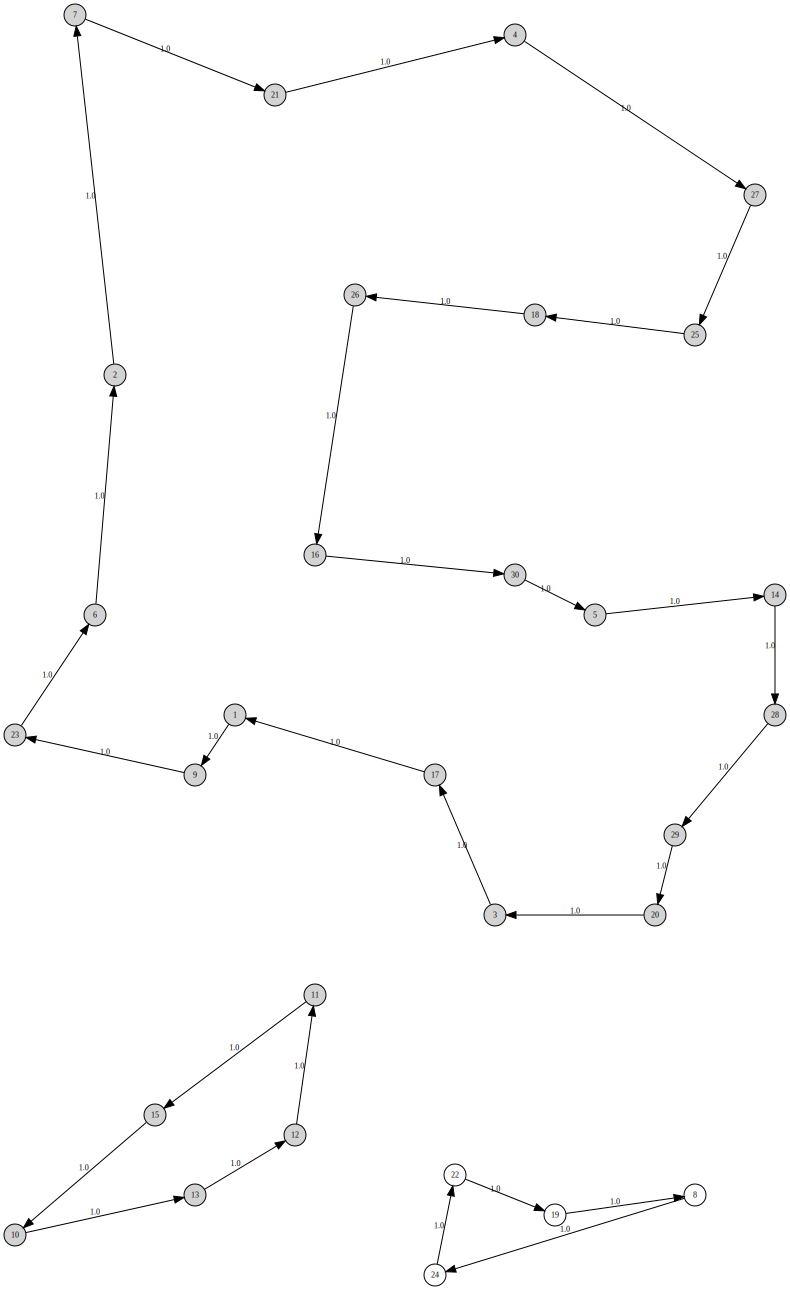

Optimize a model with 500 rows, 870 columns and 4580 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9083000e+04   1.000000e+00   0.000000e+00      0s
      12    2.9312000e+04   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.02 seconds
Optimal objective  2.931200000e+04


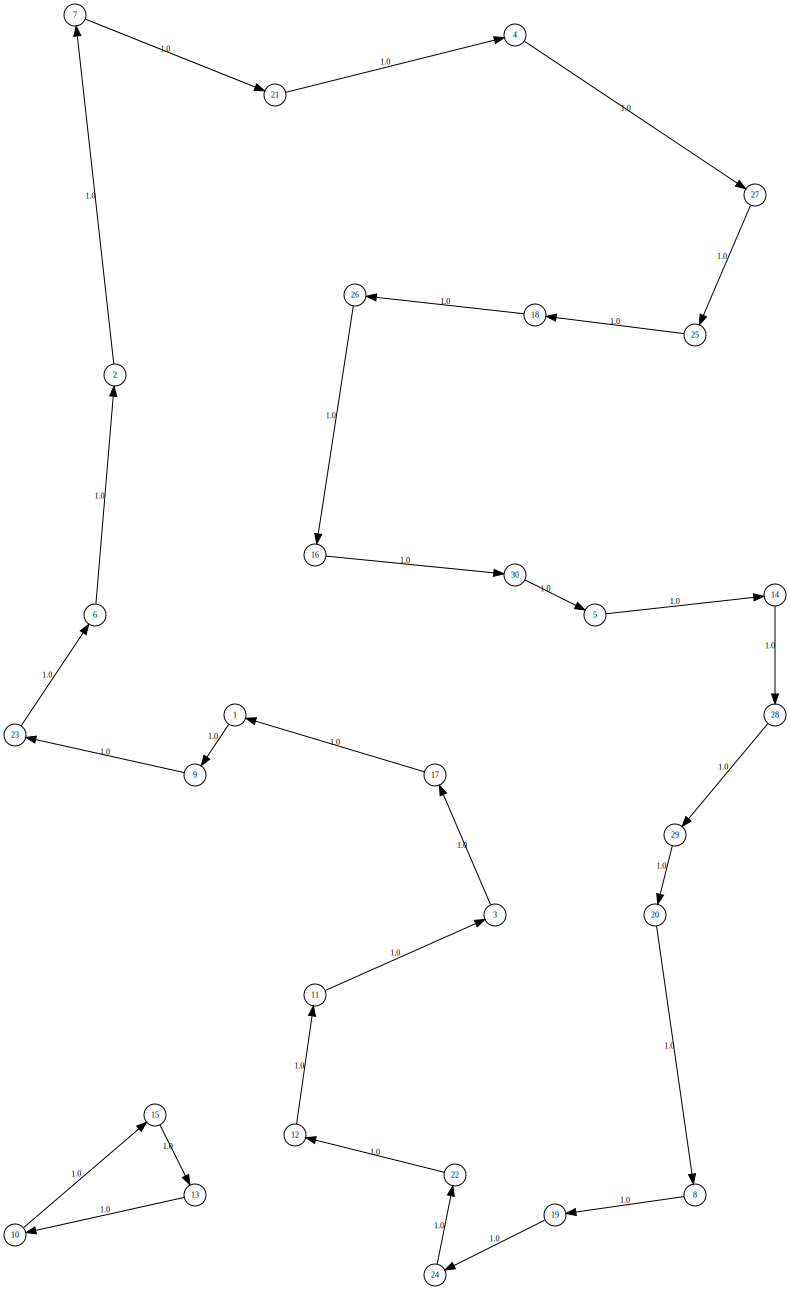

Found violated subtour inequality
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


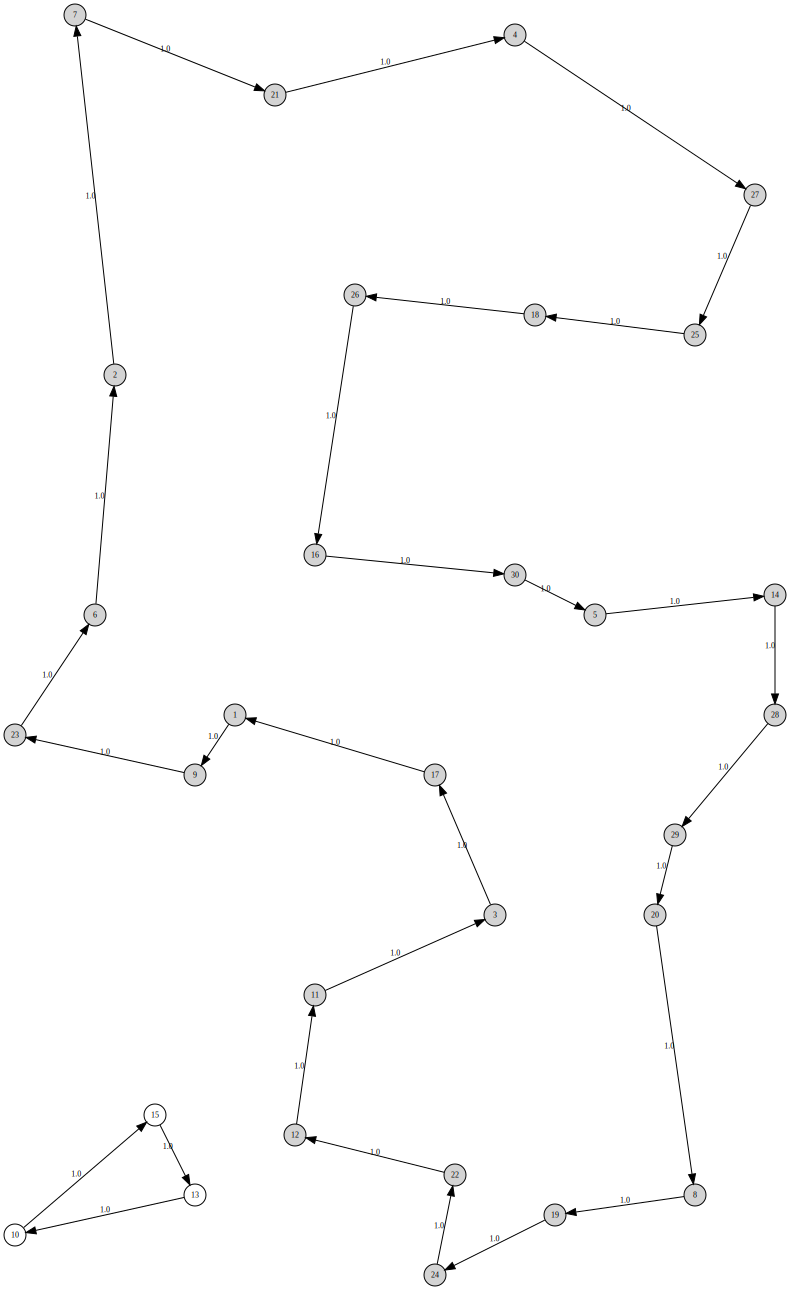

Optimize a model with 501 rows, 870 columns and 5282 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9312000e+04   1.000000e+00   0.000000e+00      0s
       8    2.9664750e+04   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.02 seconds
Optimal objective  2.966475000e+04


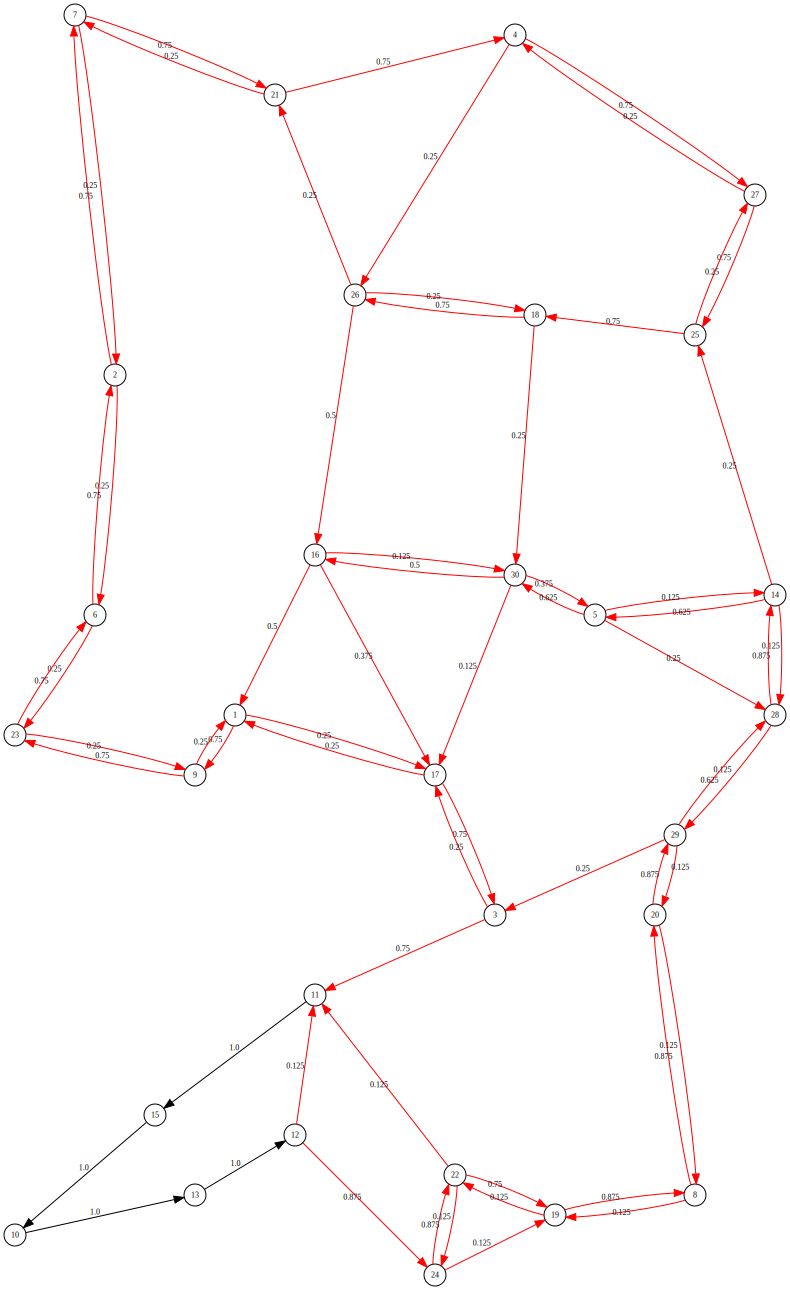

Found violated subtour inequality
[1, 2, 4, 5, 6, 7, 9, 14, 16, 17, 18, 21, 23, 25, 26, 27, 28, 30]


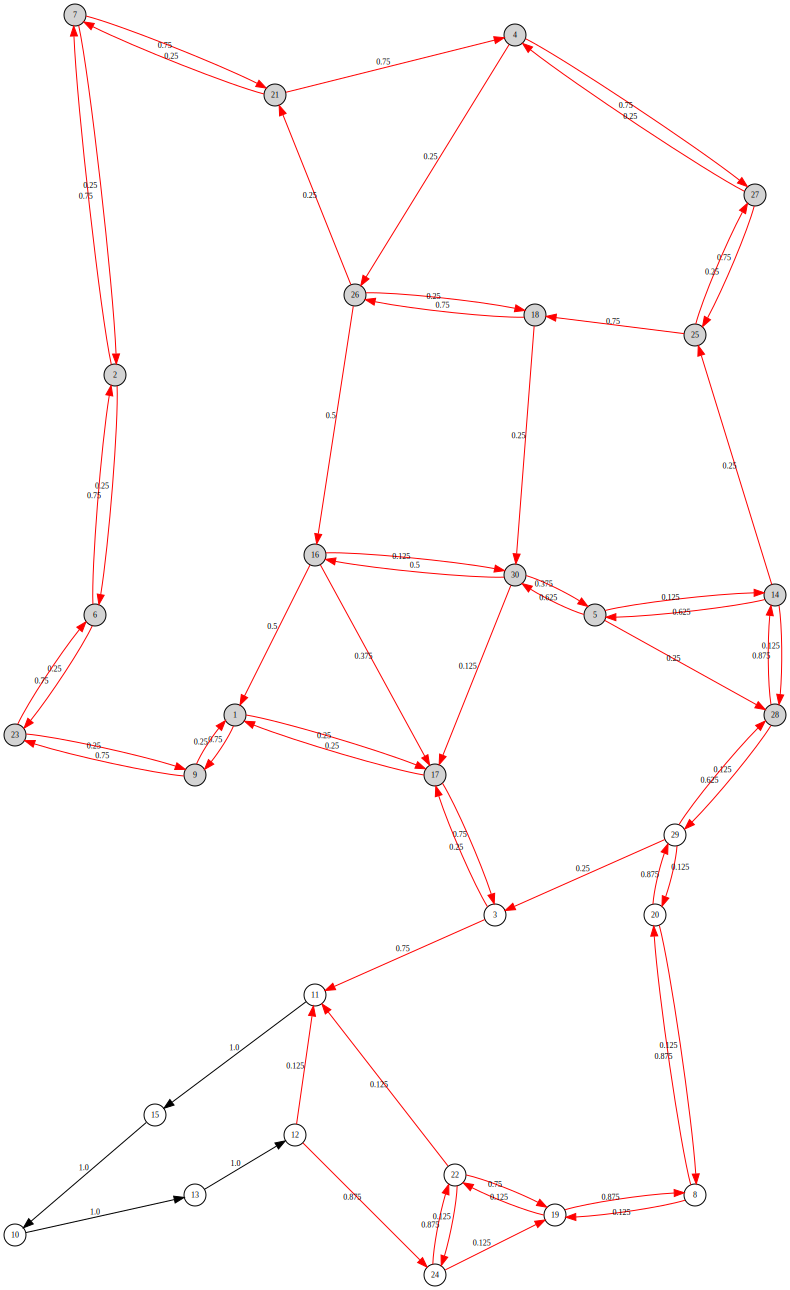

Optimize a model with 502 rows, 870 columns and 5588 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9664750e+04   1.250000e-01   0.000000e+00      0s
       3    2.9696333e+04   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.04 seconds
Optimal objective  2.969633333e+04


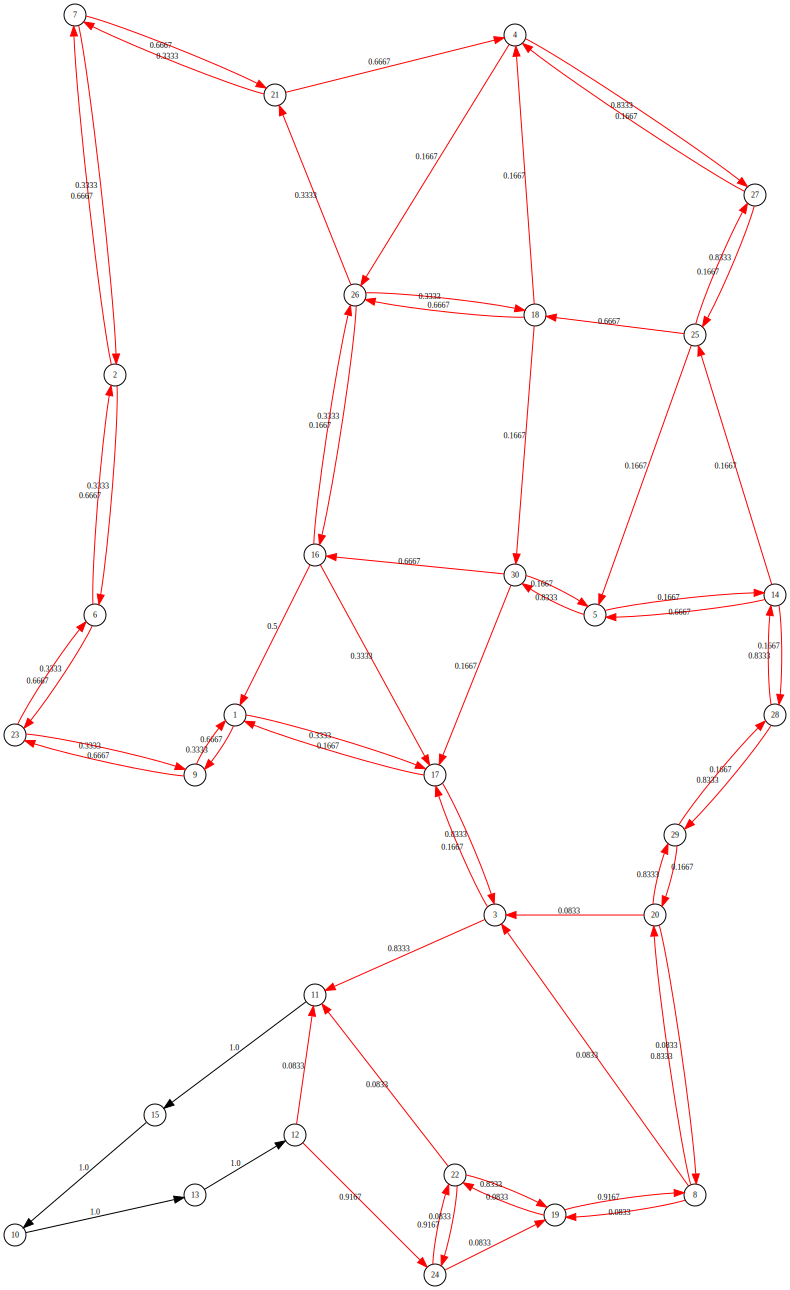

Found violated subtour inequality
[1, 2, 3, 4, 5, 6, 7, 9, 14, 16, 17, 18, 20, 21, 23, 25, 26, 27, 28, 29, 30]


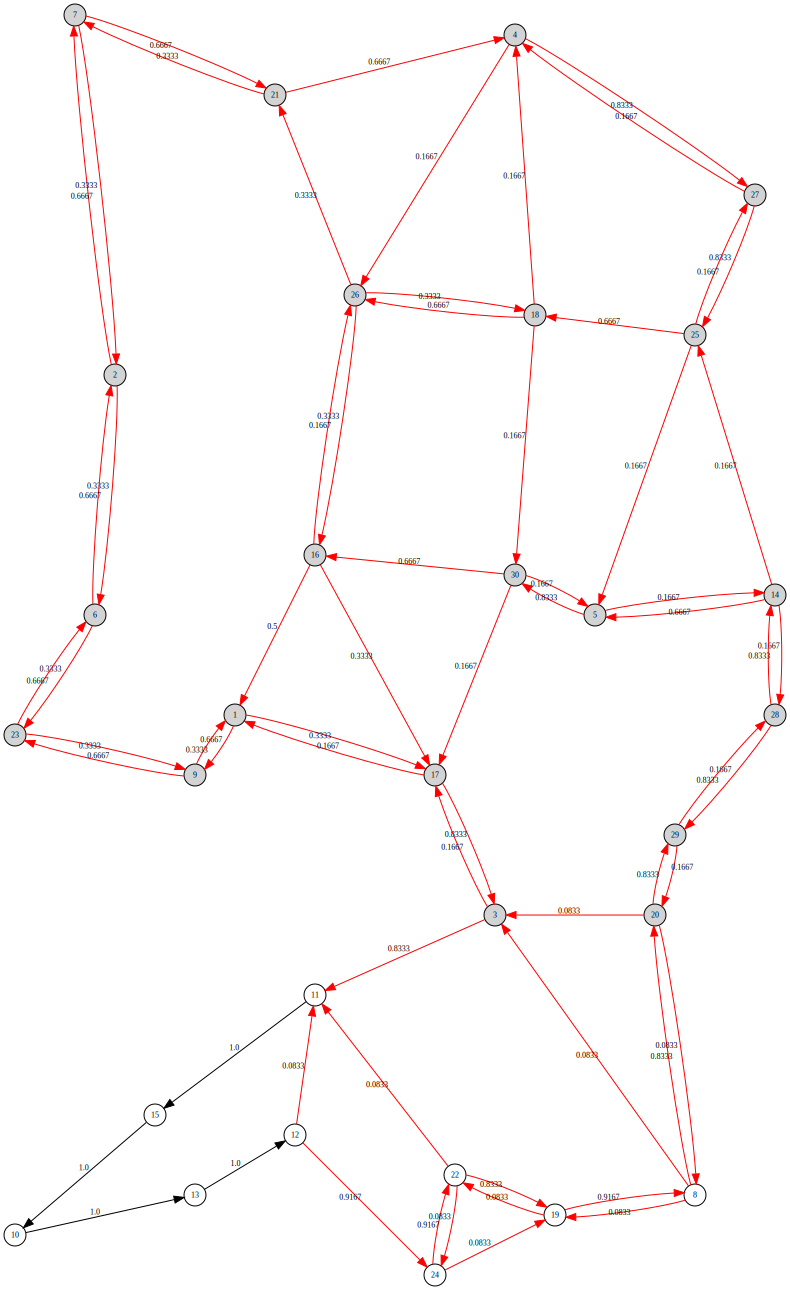

Optimize a model with 503 rows, 870 columns and 6008 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9696333e+04   8.333333e-02   0.000000e+00      0s
       1    2.9698500e+04   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.04 seconds
Optimal objective  2.969850000e+04


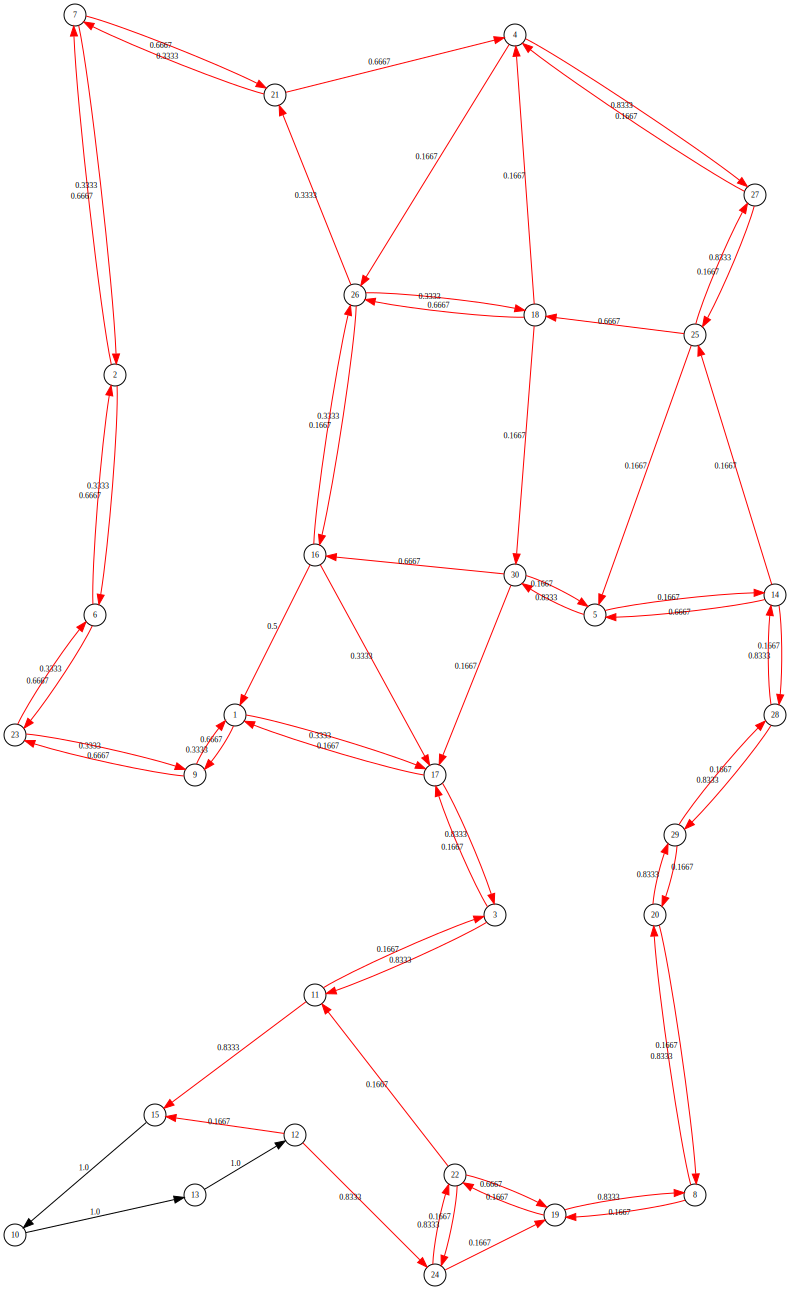

Found violated subtour inequality
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


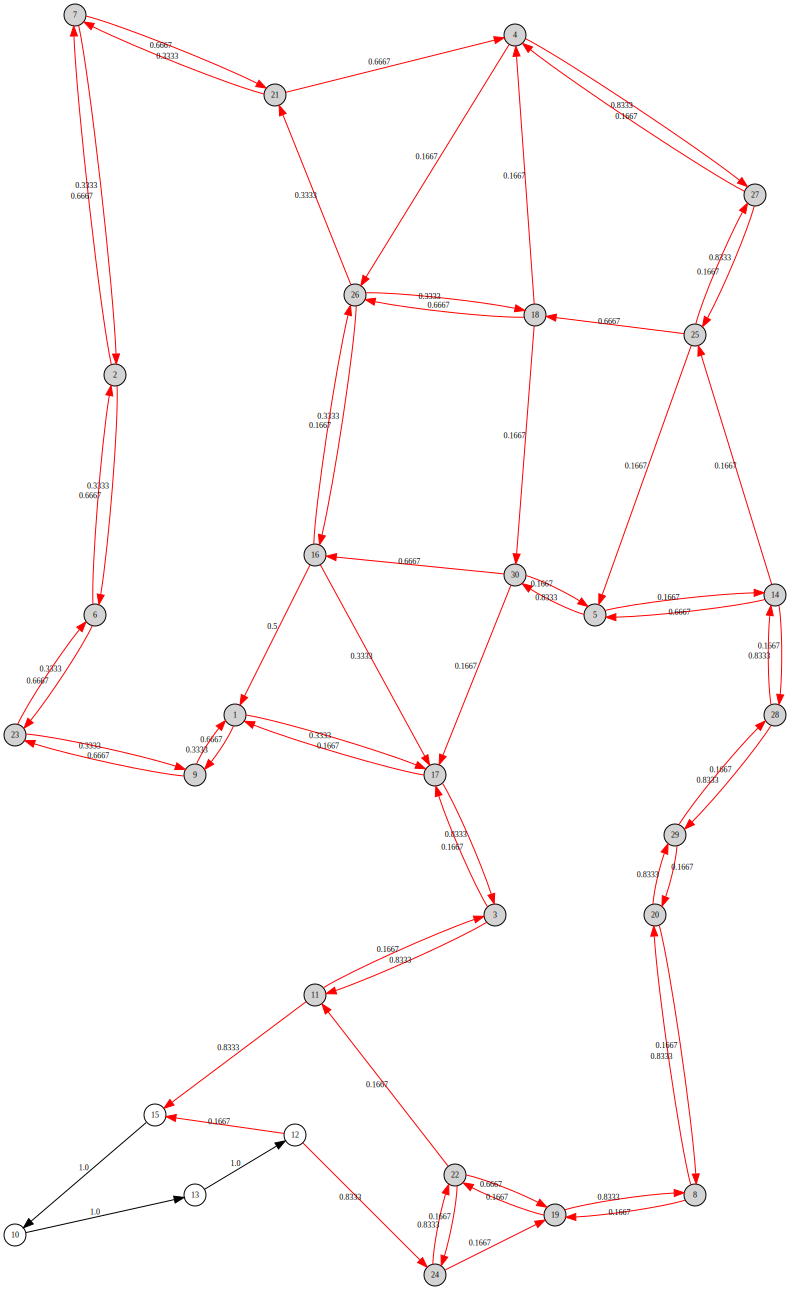

Optimize a model with 504 rows, 870 columns and 6658 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9698500e+04   1.666667e-01   0.000000e+00      0s
       1    2.9698667e+04   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.02 seconds
Optimal objective  2.969866667e+04


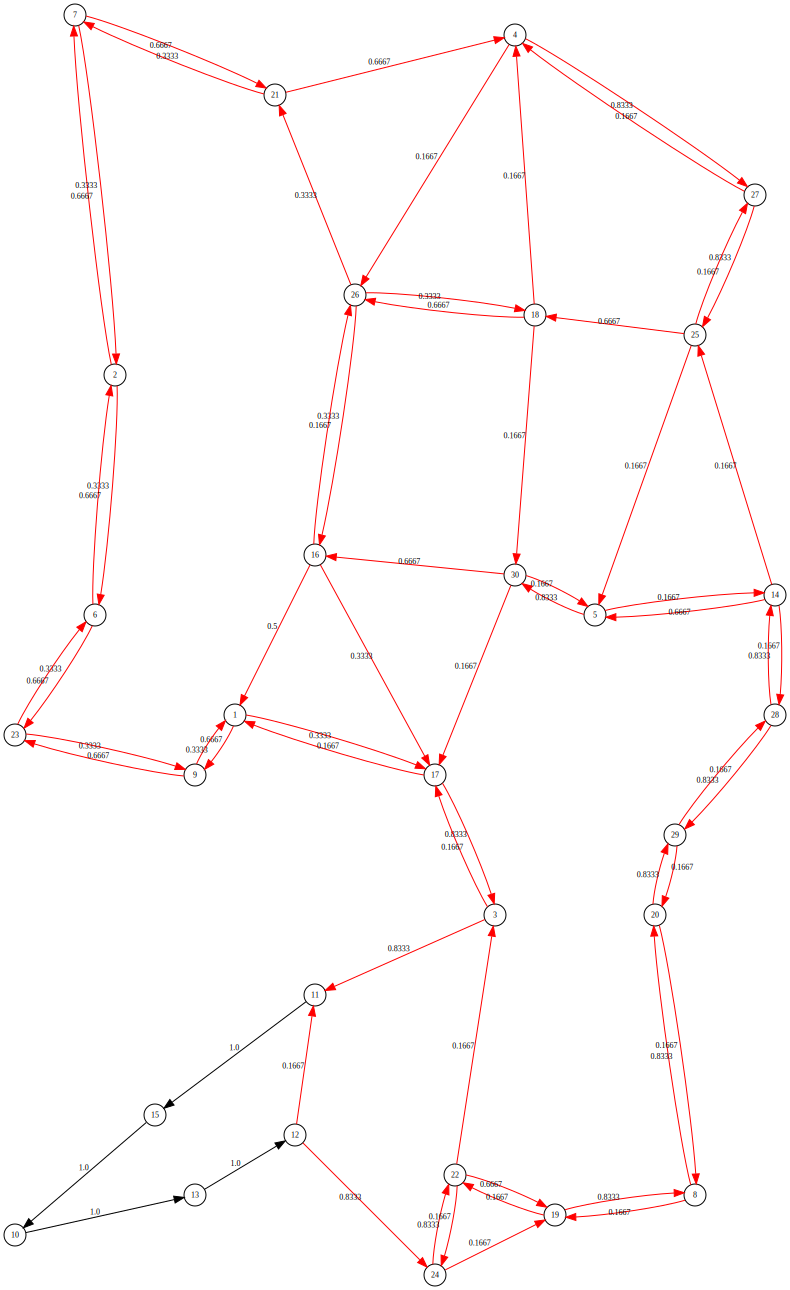

Found violated subtour inequality
[1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


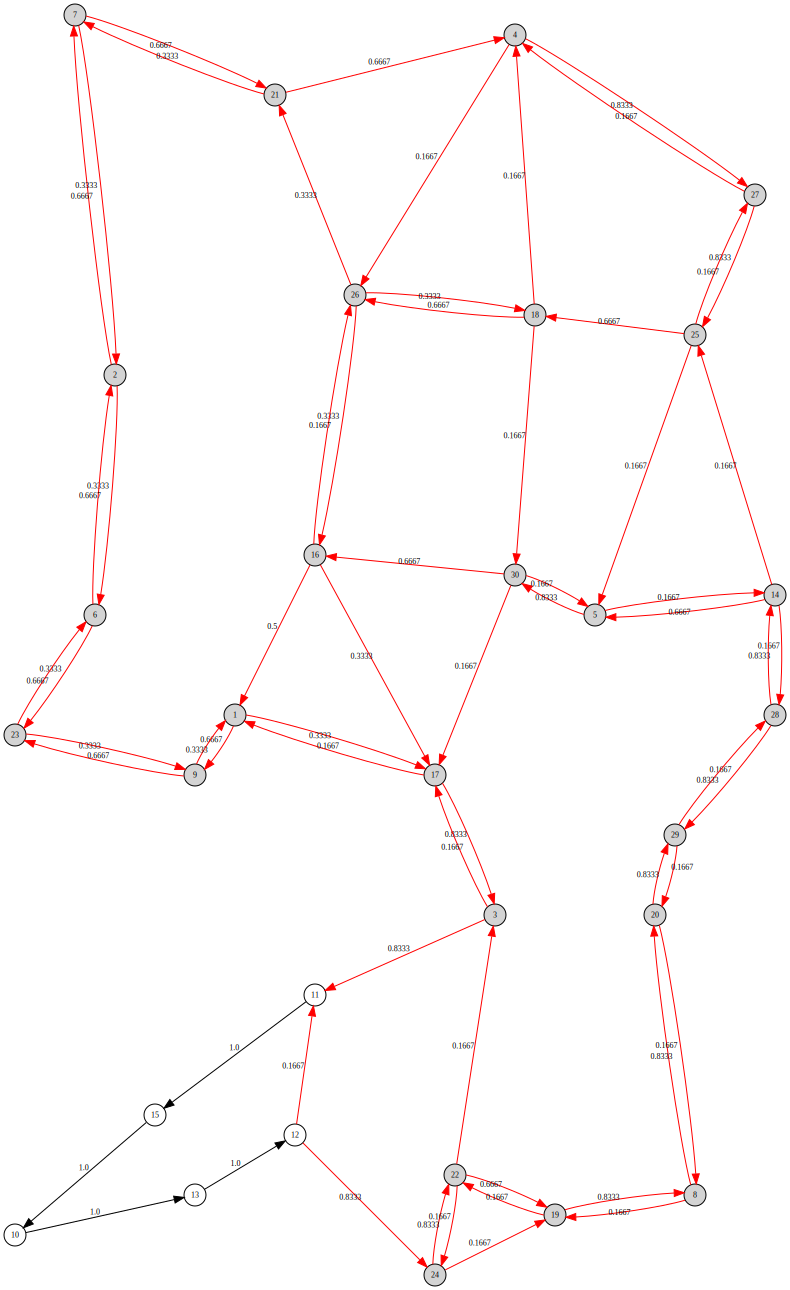

Optimize a model with 505 rows, 870 columns and 7258 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 7e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+01]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9698667e+04   1.666667e-01   0.000000e+00      0s
       1    2.9703875e+04   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds
Optimal objective  2.970387500e+04


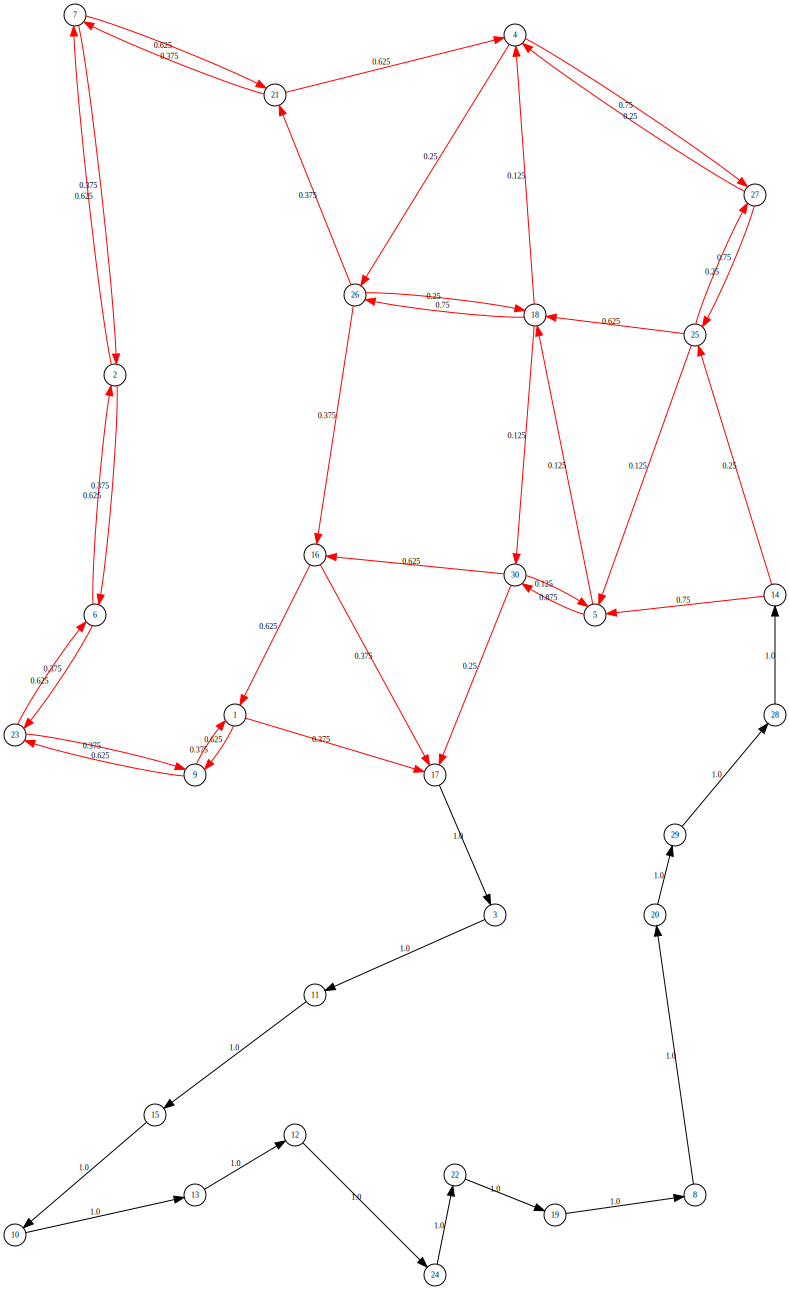

In [27]:
cuttingplane = True

count = 1
found = False

while cuttingplane == True:
    subtour = subtourseparation(G,x)
    if subtour :
        name = "Subtour_" + str(count)
        subtouredges = [(u,v) \
                        for u in subtour \
                        for v in subtour if u != v and G.has_edge(u,v)]
        DrawSubtour(x, subtour)
        display(SVG(filename=basename+'_sub.svg'))

        
        atsp.addConstr (gb.quicksum(x[i,j] for i,j in subtouredges) <= len(subtour) - 1, name)
        atsp.write('atsp.lp')
        atsp.optimize()
        
        DrawSol(x) 
        
        display(SVG(filename=basename+'_sol.svg'))
        count += 1
        cuttingplane = True
    else:
        cuttingplane = False




## ATSP: Branch-and-cut

In [ ]:
atsp_sec = gb.Model()

x = atsp_sec.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

atsp_sec.write('atsp_sec.lp')

In [ ]:
atsp_sec.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes()), name='FS')

atsp_sec.update()
atsp_sec.write('atsp.lp')

In [ ]:
atsp_sec.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes()), name='RS')

atsp_sec.update()
atsp_sec.write('atsp.lp')

In [ ]:
atsp_sec.addConstrs((x[i,j] + x[j,i] <= 1 \
                 for i,j in G.edges() if j > i), name='SUB2')

atsp_sec.update()
atsp_sec.write('atsp.lp')

### Graph G and variables x are made available to Gurobi model
**Note** underscore is the attribute name is mandatory

In [ ]:
atsp_sec._graph = G
atsp_sec._vars = x



In [ ]:
def SECcallback (model, where):

        
    if where == gb.GRB.Callback.MIPSOL:
        
        x = model._vars
        xrel = model.cbGetSolution(x)
        G = model._graph
                
        for i,j in G.edges():
            G[i][j]['capacity'] = xrel[i,j]
        
        for i in list(G.nodes())[1:]:
            cut_val, cut = nx.minimum_cut(G,1,i)
        
            if cut_val < 0.99999:
                subtour = (list(cut[0]))
        
                subtouredges = [(u,v) for u in subtour for v in subtour if u != v and G.has_edge(u,v)]

                model.cbLazy(gb.quicksum(x[i,j] for i,j in subtouredges) <= len(subtour) - 1)
                break
                

In [ ]:
atsp_sec.Params.lazyConstraints = 1
atsp_sec.optimize(SECcallback)

In [ ]:
DrawSol(x)

display(SVG(filename=basename+'_sol.svg'))

## ATSP: compact formulation

Miller-Tucker-Zemlin formulation
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N \;\; \text{(RS)}\\
u_i - u_j + 1 & \le (n-1)(1-x_{ij}) \;\; \forall (i,j) \in A, i\not=1,j\not=1 \;\; \text{(MTZ)}\\
x & \in \{0,1\}^{|A|}\\
u_1 &= 1\\
2 &\le u_i \le n \;\; \forall i \in N, \not = \{1\}
\end{alignat}
$$

Miller-Tucker-Zemlin lifted formulation (Desrochers-Laporte)
$$
\begin{alignat}{3}
& \min \sum_{(i,j) \in A} x_{ij} &\\
\text{s.t.} \;\;\;\;\;&\\
\sum_{j \in \delta^+(i)} x_{ij} &= 1 \;\; \forall i \in N \;\; \text{(FS)}\\
\sum_{j \in \delta^-(i)} x_{ji} &= 1 \;\; \forall i \in N \;\; \text{(RS)}\\
u_i - u_j + (n-1)x_{ij} + (n-3)x_{ji} &\le n-2 \;\; \forall (i,j) \in A, i\not=1,j\not=1 \;\; \text{(MTZ)}\\
x & \in \{0,1\}^{|A|}\\
u_1 &= 1\\
2 &\le u_i \le n \;\; \forall i \in N, \not = \{1\}
\end{alignat}
$$


In [28]:
atsp_mtz = gb.Model()

x = atsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

u = atsp_mtz.addVars(G.nodes(), obj=[0.0 for i in G.nodes()],\
                     lb=2.0, ub=G.number_of_nodes(), vtype=gb.GRB.CONTINUOUS,\
                    name='u')

atsp_mtz.write('atsp_mtz.lp')

In [29]:
atsp_mtz.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes()), name='FS')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [30]:
atsp_mtz.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes()), name='RS')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

## Lifted Miller-Tucker-Zemlin constraints

In [31]:
u[root].lb = 1.0
u[root].ub = 1.0

u[10] = 11
u[20] = 21

In [32]:
atsp_mtz.addConstrs((u[i] - u[j] + (G.number_of_nodes() - 1) * x[i,j] + \
                   (G.number_of_nodes() - 3) * x[j,i] <= (G.number_of_nodes() - 2)\
                   for i in G.nodes()\
                    for j in G.nodes()\
                   if (i != j) and (i != root) and (j !=root) \
                     and G.has_edge(i,j) and G.has_edge(j,i)), name='MTZ')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [33]:
atsp_mtz.optimize()

Optimize a model with 872 rows, 900 columns and 4876 nonzeros
Variable types: 30 continuous, 870 integer (870 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [4e+02, 7e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 2 rows and 5 columns
Presolve time: 0.01s
Presolved: 870 rows, 895 columns, 4868 nonzeros
Variable types: 27 continuous, 868 integer (868 binary)

Root relaxation: objective 2.885066e+04, 138 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 28850.6552    0   18          - 28850.6552      -     -    0s
     0     0 28892.3811    0   54          - 28892.3811      -     -    0s
     0     0 28892.3811    0   54          - 28892.3811      -     -    0s
     0     0 28894.3069    0   54          - 28894.3069      -     -    0s
H    0     0                    6758

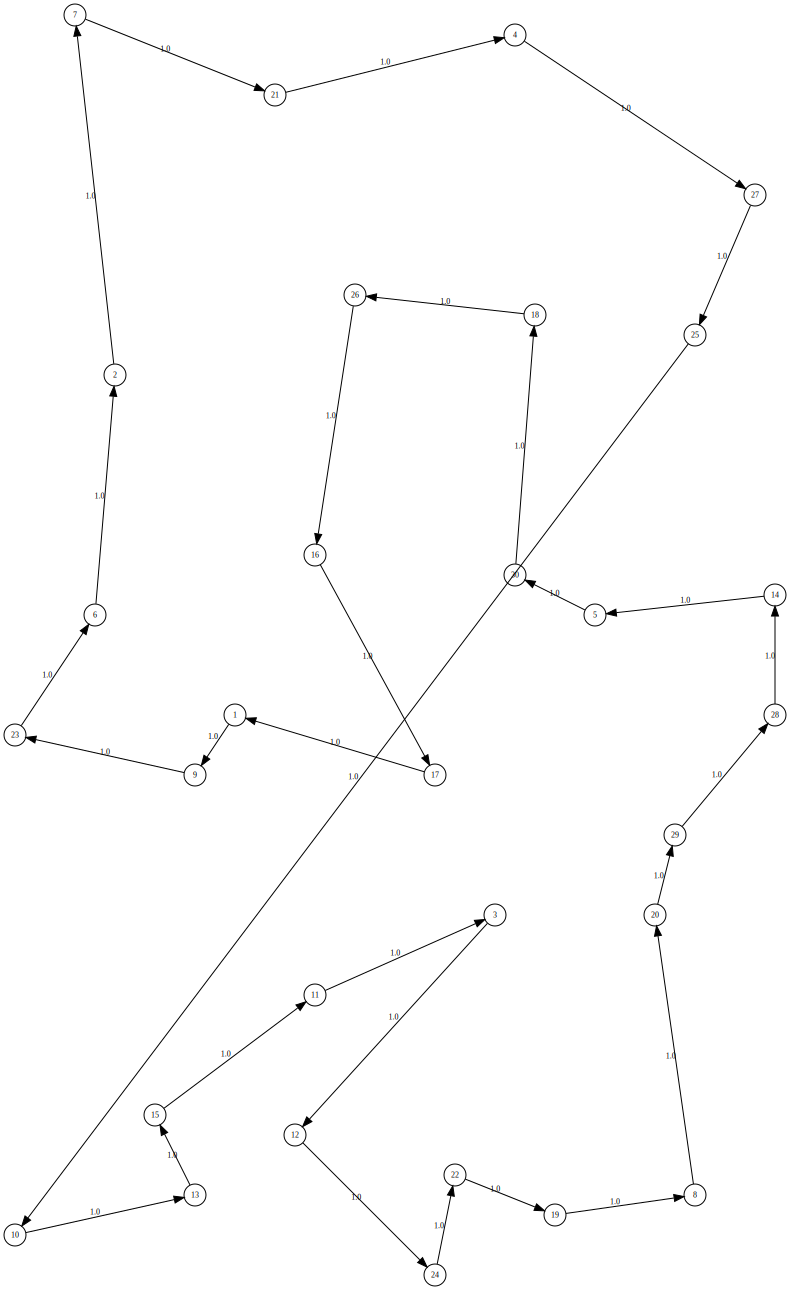

In [34]:
DrawSol(x)

display(SVG(filename=basename+'_sol.svg'))

## Mixing-up formulations

In [ ]:
atsp_mtz = gb.Model()

x = atsp_mtz.addVars(G.edges(),\
                 obj=[G[i][j]['dist']\
                      for i,j in G.edges()],\
             vtype=gb.GRB.BINARY, name='x')

u = atsp_mtz.addVars(G.nodes(), obj=[0.0 for i in G.nodes()],\
                     lb=2.0, ub=G.number_of_nodes(), vtype=gb.GRB.CONTINUOUS,\
                    name='u')

atsp_mtz.write('atsp_mtz.lp')

In [ ]:
atsp_mtz.addConstrs((x.sum(i,'*') == 1 \
                 for i in G.nodes()), name='FS')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [ ]:
atsp_mtz.addConstrs((x.sum('*',i) == 1 \
                 for i in G.nodes()), name='RS')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [ ]:
atsp_mtz.addConstrs((x[i,j] + x[j,i] <= 1 \
                 for i,j in G.edges() if j > i), name='SEC2')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [ ]:
u[root].lb = 1.0
u[root].ub = 1.0

In [ ]:
atsp_mtz.addConstrs((u[i] - u[j] + (G.number_of_nodes() - 1) * x[i,j] + \
                   (G.number_of_nodes() - 3) * x[j,i] <= (G.number_of_nodes() - 2)\
                   for i in G.nodes()\
                    for j in G.nodes()\
                   if (i != j) and (i != 1) and (j !=1 ) and G.has_edge(i,j) and G.has_edge(j,i)), name='MTZ')

atsp_mtz.update()
atsp_mtz.write('atsp_mtz.lp')

In [ ]:
atsp_mtz._vars = x
atsp_mtz._graph = G

In [ ]:
def SECcallback (model, where):

    if where == gb.GRB.Callback.MIPNODE:
        status = model.cbGet(gb.GRB.Callback.MIPNODE_STATUS)
        if status == gb.GRB.OPTIMAL:
            x = model._vars
            xrel = model.cbGetNodeRel(x) 
            G = model._graph

            for i,j in G.edges():
                G[i][j]['capacity'] = xrel[i,j]

            for i in list(G.nodes())[1:]:
                cut_val, cut = nx.minimum_cut(G,1,i)

                if cut_val < 0.99999:
                    #print ('Found violated subtour inequality')
                    subtour = (list(cut[0]))

                    subtouredges = [(u,v) for u in subtour \
                                for v in subtour if u != v and G.has_edge(u,v)]

                    model.cbCut(gb.quicksum(x[i,j] for i,j in subtouredges) <= len(subtour) - 1)

                    break



In [ ]:
atsp_mtz.reset()
atsp_mtz.Params.PreCrush = 1
atsp_mtz.optimize(SECcallback)


In [ ]:
DrawSol(x)


In [ ]:
display(SVG(filename=basename+'_sol.svg'))